In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
%load_ext tensorboard

In [18]:
InputData = np.loadtxt("dataInput2.csv",delimiter=",")
OutputData = np.loadtxt ("dataOutput2.csv", delimiter=",")

In [19]:
InputDataTrain = InputData[0:900]
InputDataTest = InputData[900:1106]

OutputDataTrain = OutputData[0:900]
OutputDataTest = OutputData[900:1106]

In [20]:
scaler = MinMaxScaler(feature_range=(-1, 1))

InputDataTrain_transformed = scaler.fit_transform(InputDataTrain)
InputDataTrain_retransformed = scaler.inverse_transform(InputDataTrain_transformed)

InputDataTest_transformed = scaler.fit_transform(InputDataTest)
InputDataTest_retransformed = scaler.inverse_transform(InputDataTest_transformed)

OutputDataTrain_transformed = scaler.fit_transform(OutputDataTrain)
OutputDataTrain_retransformed = scaler.inverse_transform(OutputDataTrain_transformed)

OutputDataTest_transformed = scaler.fit_transform(OutputDataTest)
OutputDataTest_retransformed = scaler.inverse_transform(OutputDataTest_transformed)               


In [21]:
print(OutputDataTest[150])
print(OutputDataTest_retransformed[150])
print(OutputDataTest-OutputDataTest_retransformed)

[ -4.73251161  -0.30027737  -6.27910164   6.25288937   4.87323615
  -9.18637698  -9.75336607   6.43547958   2.87583791   2.52918693
  -2.29865586  17.66568722 -20.06186346   1.84026081  10.29989395
   6.26354859 -15.73546844   1.79417161  17.6639779  -19.16150446
   5.96861094  -2.11536077  -5.05026322   8.84964708 -16.88682626
  13.19593765   4.24076097   1.2031443  -11.6599997    5.65939556
 -11.69949576]
[ -4.73251161  -0.30027737  -6.27910164   6.25288937   4.87323615
  -9.18637698  -9.75336607   6.43547958   2.87583791   2.52918693
  -2.29865586  17.66568722 -20.06186346   1.84026081  10.29989395
   6.26354859 -15.73546844   1.79417161  17.6639779  -19.16150446
   5.96861094  -2.11536077  -5.05026322   8.84964708 -16.88682626
  13.19593765   4.24076097   1.2031443  -11.6599997    5.65939556
 -11.69949576]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   

In [22]:
def create_model() :
    return tf.keras.models.Sequential([
      tf.keras.Input(shape=((31,))),
      tf.keras.layers.Dense(62,input_dim = 31, activation='tanh'),
      tf.keras.layers.Dense(62,input_dim = 62, activation='tanh'),
      tf.keras.layers.Dense(31)
    ])

In [23]:
model = create_model()
model

In [24]:
model.summary()
model.output_shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 62)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_2 (Dense)              (None, 31)                1953      
Total params: 7,843
Trainable params: 7,843
Non-trainable params: 0
_________________________________________________________________


(None, 31)

In [25]:
model.layers

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=InputDataTrain_transformed, 
          y=OutputDataTrain_transformed, 
          epochs=200, 
          batch_size = 50,
          validation_data=(InputDataTest_transformed, OutputDataTest_transformed), 
          callbacks=[tensorboard_callback])

Epoch 1/200

 1/18 [>.............................] - ETA: 0s - loss: 0.3381 - accuracy: 0.0200WARNING:tensorflow:From C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

18/18 [==============================] - 0s 13ms/step - loss: 0.2558 - accuracy: 0.0411 - val_loss: 0.2266 - val_accuracy: 0.0874
Epoch 2/200

18/18 [==============================] - 0s 2ms/step - loss: 0.1359 - accuracy: 0.1200 - val_loss: 0.1352 - val_accuracy: 0.1456
Epoch 3/200

18/18 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.2256 - val_loss: 0.0888 - val_accuracy: 0.2816
Epoch 4/200

18/18 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.3200 - val_loss: 0.0622 - val_accuracy: 0.3544
Epoch 5/200

18/18 [==============================] - 0s 

In [17]:
# %tensorboard --logdir logs --host localhost --port 6003

Launching TensorBoard...
ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13564.


In [27]:
results = model.evaluate(InputDataTest_transformed,OutputDataTest_transformed)
print("test loss, test acc:", results)


7/7 [==============================] - 0s 571us/step - loss: 0.0023 - accuracy: 0.7864
test loss, test acc: [0.002282155677676201, 0.7864077687263489]


In [31]:
predictions = model.predict(InputDataTest_transformed[:1])
print("predictions shape:", predictions.shape)
print("InputDataTest:",InputDataTest_transformed[:1])
print("InputDataTest in db (Command Gains)", InputDataTest_retransformed[:1])
print("OutputDataTest:",OutputDataTest_transformed[:1])
print("Predictions:",predictions)

print("OutputDataTest in dB:",scaler.inverse_transform(OutputDataTest_transformed[:1]))
print("predictions in dB",scaler.inverse_transform(predictions))

predictions shape: (1, 31)
InputDataTest: [[-0.03466383  0.34809011 -0.59464985 -0.15562611 -0.15711025 -0.79646907
   0.76169586  0.85509516 -0.50185114  0.69665919  0.18144176 -0.2072875
  -0.68531927  0.23033545  0.5057882   0.90587085 -0.55252488  0.81558184
  -0.49117863 -0.63547965  0.47213352  0.59485527  0.17042653  0.06738249
   0.90220788 -0.35267129  0.04902007 -0.68812842  0.65167276 -0.21194042
   0.86687475]]
InputDataTest in db (Command Gains) [[-0.41596599  4.17708137 -7.13579825 -1.86751326 -1.88532298 -9.5576289
   9.14035035 10.26114197 -6.02221366  8.35991031  2.17730111 -2.48745005
  -8.2238312   2.7640254   6.06945842 10.87045014 -6.63029852  9.78698205
  -5.89414359 -7.62575583  5.66560218  7.13826321  2.04511832  0.80858992
  10.8264946  -4.23205547  0.58824085 -8.257541    7.82007313 -2.54328503
  10.40249703]]
OutputDataTest: [[-0.12737358  0.33080858 -0.37869324  0.05708637  0.05681937 -0.56850126
   0.44650325  0.46580371 -0.60256695  0.4789748  -0.0038206  

In [19]:
model.output_shape

(None, 31)

In [15]:
e = np.ones(31).reshape((1,31)) * 12
e

array([[12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12.]])

In [100]:
 c= model.predict(e)

In [101]:
c

array([[ 0.7920612 ,  0.24975286,  0.93639535,  0.43934783,  0.37545347,
         0.32991934, -0.1991137 ,  0.535629  ,  0.45578828,  0.4444485 ,
         0.7452018 ,  0.7698743 ,  0.1903496 ,  0.20594095,  0.25968784,
         0.36222196,  0.38786915,  0.9961614 ,  0.45667306,  0.9531399 ,
         0.81013477, -0.13264985,  0.8795392 ,  0.09648261,  0.72876805,
         0.16417289,  0.3445992 ,  0.5409347 ,  0.6000062 ,  0.3769791 ,
         2.5566206 ]], dtype=float32)

In [102]:
c_retransformed = scaler.inverse_transform(c)    

In [103]:
c_retransformed

array([[15.408945 ,  6.6694436, 24.849407 , 11.760467 , 10.52049  ,
         8.482164 , -5.4901333, 14.247391 , 12.496476 , 11.915847 ,
        20.081142 , 20.480686 ,  5.035654 ,  5.299079 ,  6.6581144,
         9.759419 , 10.212843 , 26.480726 , 12.198938 , 25.439228 ,
        21.89083  , -3.812895 , 22.69289  ,  3.1367729, 19.719358 ,
         4.3953867,  8.788185 , 14.219541 , 15.225162 ,  8.70934  ,
        36.407856 ]], dtype=float32)

In [111]:
InputDataTest[202:206]

array([[-12.,   0.,   0.,   0.,  12.,   0.,   0.,   0.,  12.,   0., -12.,
         12., -12., -12.,  12.,   0.,   0.,  12., -12., -12.,   0.,  12.,
         12.,  12., -12.,  12.,  12.,  12., -12., -12.,   0.],
       [  0., -12., -12.,   0.,  12., -12., -12., -12.,  12.,   0.,  12.,
        -12., -12.,   0.,   0., -12.,  12.,  12.,   0.,   0., -12., -12.,
          0.,  12.,  12.,  12., -12.,   0.,  12.,   0., -12.],
       [ 12.,  12., -12., -12., -12.,   0., -12.,   0.,  12., -12.,   0.,
         12.,  12.,  12.,  12.,   0., -12., -12.,   0.,  12., -12.,  12.,
        -12.,  12., -12.,  12.,   0., -12.,  12.,   0., -12.],
       [-12., -12.,  12.,   0.,   0.,  12.,   0.,   0., -12.,  12.,  12.,
         12., -12.,  12.,  12.,  12.,  12.,  12.,   0., -12.,  12.,   0.,
          0.,  12., -12.,  12., -12., -12.,   0.,  12., -12.]])

C:/Users/Robert/AppData/Local/Temp/xpython_9904/2936004681.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gopt_db = np.linalg.lstsq(leak.conj().T, G_db2)[0]
C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

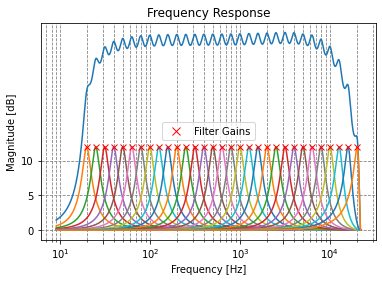

In [47]:
%run Code.ipynb

In [40]:
commandGains = InputDataTest_retransformed[:1].reshape((31,1))
filterGainsPredicted = scaler.inverse_transform(predictions).reshape((31,1))

C:/Users/Robert/AppData/Local/Temp/xpython_9904/2936004681.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gopt_db = np.linalg.lstsq(leak.conj().T, G_db2)[0]
C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

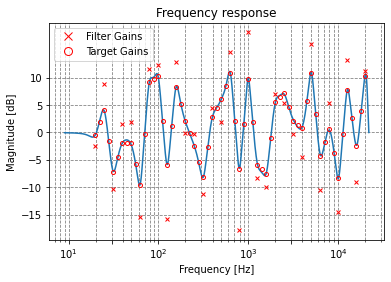

C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num = np.array([(1+G*beta), -2*cos(w0), (1-G*beta)]/(1+beta))
C:/Users/Robert/AppData/Local/Temp/xpython_9904/4126492185.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  den = np.array([1, -2*cos(w0)/(1+beta), (1-beta)/(1+beta)])


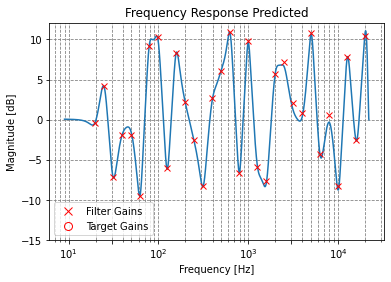

In [48]:
%matplotlib inline
thirdOctaveGEQwithPredictions(commandGains,filterGainsPredicted)